# CS188 Final Project - NEXT Trucking

In [1]:
# Importing many libraries from past projects
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from scipy import stats
import datetime


from matplotlib import pyplot
import itertools

%matplotlib inline

import random 
  
random.seed(42)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#if using google colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#if using local env
#import tarfile
#import urllib
#DATASET_PATH = ""

#def load_data(dpath):
#    csv_path = os.path.join(dpath, "training_dataset_V3.csv")
#    return pd.read_csv(csv_path)

#dirty_data = load_data(DATASET_PATH)

#def load_data2(dpath):
#    csv_path = os.path.join(dpath, "score_V3.csv")
#    return pd.read_csv(csv_path)

#kaggle_dirty = load_data2(DATASET_PATH)

#dirty_data.head()

In [4]:
#if using google colab
DATASET_PATH = os.path.join("/content/gdrive/My Drive")

csv_path = os.path.join(DATASET_PATH, "training_dataset_V3.csv")
dirty_data = pd.read_csv(csv_path)

csv_path = os.path.join(DATASET_PATH, "score_V3.csv")
kaggle_dirty = pd.read_csv(csv_path)

#See fiirst few rows of data
dirty_data.head()

,Unnamed: 0,dt,weekday,year,id_driver,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,signup_source,ts_signup,ts_first_approved,days_signup_to_approval,driver_with_twic,dim_preferred_lanes,first_load_date,most_recent_load_date,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
0,0,2019-12-16,Monday,2019,21350,U0109015,Owner Operator,CA&F TRUCKING,Maywood,CA,"[""poweronly""]",1.0,yes,yes,Other,2019-04-08 18:19:00+00:00,2019-04-22 18:49:47+00:00,14.0,yes,NaN,2019-10-24,2021-02-17,2019-12-16,2,0,438,438,0,45,45,483
1,1,2021-01-15,Friday,2021,36437,C0097727,Fleet,New opportunities inc,Los Angeles,CA,"[""poweronly"", ""boxtruck""]",15.0,yes,yes,Mobile,2020-04-18 01:01:13+00:00,2020-05-06 22:09:23+00:00,18.0,no,NaN,2020-10-14,2021-02-03,2021-01-15,1,2,72,74,0,1,1,75
2,2,2019-12-26,Thursday,2019,19323,U0107081,Owner Operator,RAS,Compton,CA,"[""poweronly""]",1.0,yes,yes,Other,2019-02-11 08:43:49+00:00,2019-07-17 20:35:13+00:00,156.0,yes,NaN,2019-12-12,2020-09-25,2019-12-26,1,0,180,180,0,2,2,182
3,3,2021-02-10,Wednesday,2021,34809,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,2019-03-04 20:50:37+00:00,2019-03-04 21:03:38+00:00,0.0,yes,NaN,2020-06-18,2021-02-17,2021-02-10,3,0,0,0,0,0,0,62
4,4,2017-07-24,Monday,2017,4728,U0094376,Owner Operator,joes transportation,Norco,CA,"[""dryvan""]",1.0,not specified,no,Other,2017-01-17 00:05:12+00:00,2019-03-22 00:26:25+00:00,794.0,no,NaN,2017-01-17,2017-10-11,2017-07-24,2,57,0,57,314,0,314,371


In [5]:
# See some null values
sample_incomplete_dirty = dirty_data[dirty_data.isnull().any(axis=1)]
sample_incomplete_dirty.head(20)

,Unnamed: 0,dt,weekday,year,id_driver,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,signup_source,ts_signup,ts_first_approved,days_signup_to_approval,driver_with_twic,dim_preferred_lanes,first_load_date,most_recent_load_date,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
0,0,2019-12-16,Monday,2019,21350,U0109015,Owner Operator,CA&F TRUCKING,Maywood,CA,"[""poweronly""]",1.0,yes,yes,Other,2019-04-08 18:19:00+00:00,2019-04-22 18:49:47+00:00,14.0,yes,NaN,2019-10-24,2021-02-17,2019-12-16,2,0,438,438,0,45,45,483
1,1,2021-01-15,Friday,2021,36437,C0097727,Fleet,New opportunities inc,Los Angeles,CA,"[""poweronly"", ""boxtruck""]",15.0,yes,yes,Mobile,2020-04-18 01:01:13+00:00,2020-05-06 22:09:23+00:00,18.0,no,NaN,2020-10-14,2021-02-03,2021-01-15,1,2,72,74,0,1,1,75
2,2,2019-12-26,Thursday,2019,19323,U0107081,Owner Operator,RAS,Compton,CA,"[""poweronly""]",1.0,yes,yes,Other,2019-02-11 08:43:49+00:00,2019-07-17 20:35:13+00:00,156.0,yes,NaN,2019-12-12,2020-09-25,2019-12-26,1,0,180,180,0,2,2,182
3,3,2021-02-10,Wednesday,2021,34809,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,2019-03-04 20:50:37+00:00,2019-03-04 21:03:38+00:00,0.0,yes,NaN,2020-06-18,2021-02-17,2021-02-10,3,0,0,0,0,0,0,62
4,4,2017-07-24,Monday,2017,4728,U0094376,Owner Operator,joes transportation,Norco,CA,"[""dryvan""]",1.0,not specified,no,Other,2017-01-17 00:05:12+00:00,2019-03-22 00:26:25+00:00,794.0,no,NaN,2017-01-17,2017-10-11,2017-07-24,2,57,0,57,314,0,314,371
6,6,2019-08-26,Monday,2019,15945,U0103984,Owner Operator,felipe gomez carranza,Ontario,CA,"[""dryvan""]",1.0,not specified,no,Other,2018-11-08 01:56:46+00:00,2018-12-03 20:44:16+00:00,25.0,no,NaN,2018-12-06,2019-12-23,2019-08-26,1,0,0,0,137,0,137,137
7,7,2021-01-04,Monday,2021,34597,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,2019-03-04 20:50:37+00:00,2019-03-04 21:03:38+00:00,0.0,yes,NaN,2020-06-11,2021-02-17,2021-01-04,1,0,0,0,0,0,0,56
8,8,2021-02-03,Wednesday,2021,36524,C0098360,Fleet,Florentino Moya,Los Angeles,CA,"[""poweronly""]",6.0,yes,yes,Other,2020-10-19 21:30:08+00:00,2020-10-20 18:08:31+00:00,0.0,yes,NaN,2020-10-22,2021-02-17,2021-02-03,2,5,109,114,0,1,1,115
9,9,2021-02-01,Monday,2021,34503,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,2019-03-04 20:50:37+00:00,2019-03-04 21:03:38+00:00,0.0,yes,NaN,2020-05-14,2021-02-17,2021-02-01,2,0,0,0,0,0,0,85
10,10,2016-09-18,Sunday,2016,150,U0090189,Owner Operator,Five Star Calif Rental Inc,Norwalk,CA,"[""dryvan""]",1.0,not specified,no,Other,2015-12-01 01:31:59+00:00,NaN,NaN,no,NaN,2015-12-01,2016-09-18,2016-09-18,3,0,0,0,35,0,35,35


# 1) Generate Labels
We will drop the duplicate index column and sort by the most recent date

In [6]:
unlabeled_data = dirty_data.drop(columns=['Unnamed: 0'])
kaggle_u_compressed = kaggle_dirty.drop(columns=['Unnamed: 0']) 
unlabeled_data.head()

,dt,weekday,year,id_driver,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,signup_source,ts_signup,ts_first_approved,days_signup_to_approval,driver_with_twic,dim_preferred_lanes,first_load_date,most_recent_load_date,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
0,2019-12-16,Monday,2019,21350,U0109015,Owner Operator,CA&F TRUCKING,Maywood,CA,"[""poweronly""]",1.0,yes,yes,Other,2019-04-08 18:19:00+00:00,2019-04-22 18:49:47+00:00,14.0,yes,NaN,2019-10-24,2021-02-17,2019-12-16,2,0,438,438,0,45,45,483
1,2021-01-15,Friday,2021,36437,C0097727,Fleet,New opportunities inc,Los Angeles,CA,"[""poweronly"", ""boxtruck""]",15.0,yes,yes,Mobile,2020-04-18 01:01:13+00:00,2020-05-06 22:09:23+00:00,18.0,no,NaN,2020-10-14,2021-02-03,2021-01-15,1,2,72,74,0,1,1,75
2,2019-12-26,Thursday,2019,19323,U0107081,Owner Operator,RAS,Compton,CA,"[""poweronly""]",1.0,yes,yes,Other,2019-02-11 08:43:49+00:00,2019-07-17 20:35:13+00:00,156.0,yes,NaN,2019-12-12,2020-09-25,2019-12-26,1,0,180,180,0,2,2,182
3,2021-02-10,Wednesday,2021,34809,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,2019-03-04 20:50:37+00:00,2019-03-04 21:03:38+00:00,0.0,yes,NaN,2020-06-18,2021-02-17,2021-02-10,3,0,0,0,0,0,0,62
4,2017-07-24,Monday,2017,4728,U0094376,Owner Operator,joes transportation,Norco,CA,"[""dryvan""]",1.0,not specified,no,Other,2017-01-17 00:05:12+00:00,2019-03-22 00:26:25+00:00,794.0,no,NaN,2017-01-17,2017-10-11,2017-07-24,2,57,0,57,314,0,314,371


In [7]:
# Sort by load_day
u_sorted_data = unlabeled_data.sort_values(by=['load_day'], axis=0, ascending=False)
u_sorted_data = u_sorted_data.reset_index().drop(columns=['index'])

u_sorted_data.head()

,dt,weekday,year,id_driver,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,signup_source,ts_signup,ts_first_approved,days_signup_to_approval,driver_with_twic,dim_preferred_lanes,first_load_date,most_recent_load_date,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
0,2021-02-17,Wednesday,2021,34586,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,2019-03-04 20:50:37+00:00,2019-03-04 21:03:38+00:00,0.0,yes,NaN,2020-06-11,2021-02-17,2021-02-17,2,0,0,0,0,0,0,131
1,2021-02-17,Wednesday,2021,34801,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,2019-03-04 20:50:37+00:00,2019-03-04 21:03:38+00:00,0.0,yes,NaN,2020-06-04,2021-02-17,2021-02-17,2,0,0,0,0,0,0,120
2,2021-02-17,Wednesday,2021,34792,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,2019-03-04 20:50:37+00:00,2019-03-04 21:03:38+00:00,0.0,yes,NaN,2020-06-04,2021-02-17,2021-02-17,2,0,0,0,0,0,0,121
3,2021-02-17,Wednesday,2021,20443,C0093895,Fleet,EJG TRUCKING,Los Angeles,CA,"[""dryvan"", ""boxtruck""]",11.0,yes,no,Other,2018-12-21 20:37:29+00:00,2018-12-21 20:44:26+00:00,0.0,no,NaN,2019-03-14,2021-02-17,2021-02-17,1,205,0,205,307,0,307,512
4,2021-02-17,Wednesday,2021,18146,U0105836,Owner Operator,Prime Transportation Services,Moreno Valley,CA,"[""poweronly""]",1.0,yes,yes,Other,2019-01-16 20:36:50+00:00,2019-01-17 19:51:44+00:00,0.0,yes,NaN,2019-01-19,2021-02-17,2021-02-17,4,48,1289,1337,3,34,37,1374


In [8]:
#Failed attempt to improve model F-score
#Improved cv accuracy but decreased F-score on test set

def get_accumulated_loads(df):
  num_entries = len(df)
  loads_per_id = {}
  for i in range(0, num_entries):
    driver = df["id_driver"][i]
    if (driver in loads_per_id):
      loads_per_id[driver].append(df["loads"][i])
    else:
      loads_per_id[driver] = [df["loads"][i]]

  for key in loads_per_id:
    loads_per_id[key] = np.sum(loads_per_id[key])

  return loads_per_id

accu_loads = get_accumulated_loads(u_sorted_data) 

Next we will drop the duplicate drivers. 
After a long discussion abnout the cumulative loads on piazza, the best way to go about this is to collapse all rows by trimming duplicate drivers. This leaves the most recent entries with the cumulative features. We will have to keep an eye out for the distribution of these cumulative features as we proceed.

In [9]:
# collapse by driver
u_sorted_data.drop_duplicates('id_driver', inplace = True)

u_compressed = u_sorted_data.sort_values(by=['load_day'], ascending=False)
u_compressed = u_compressed.reset_index().drop(columns=['index'])

u_compressed

,dt,weekday,year,id_driver,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,signup_source,ts_signup,ts_first_approved,days_signup_to_approval,driver_with_twic,dim_preferred_lanes,first_load_date,most_recent_load_date,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
0,2021-02-17,Wednesday,2021,34586,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,2019-03-04 20:50:37+00:00,2019-03-04 21:03:38+00:00,0.0,yes,NaN,2020-06-11,2021-02-17,2021-02-17,2,0,0,0,0,0,0,131
1,2021-02-17,Wednesday,2021,18349,U0106014,Owner Operator,Blue Dragon Express,Ontario,CA,"[""poweronly""]",1.0,yes,yes,Other,2019-01-22 20:16:54+00:00,2019-04-03 15:21:14+00:00,70.0,yes,NaN,2020-02-25,2021-02-17,2021-02-17,3,2,116,118,2,148,150,268
2,2021-02-17,Wednesday,2021,15704,U0103775,Owner Operator,Angel Garcia Trucking,Culver City,CA,"[""poweronly""]",1.0,not specified,no,Other,2018-10-30 22:26:35+00:00,2019-07-16 17:10:36+00:00,258.0,no,NaN,2018-11-12,2021-02-17,2021-02-17,2,0,218,218,1,56,57,275
3,2021-02-17,Wednesday,2021,37589,C0098704,Fleet,Ibarra Transportation,Bell,CA,"[""poweronly""]",3.0,yes,yes,Other,2021-01-12 18:49:28+00:00,2021-01-12 18:53:36+00:00,0.0,no,NaN,2021-01-14,2021-02-17,2021-02-17,5,0,67,67,0,1,1,68
4,2021-02-17,Wednesday,2021,36275,U0122637,Owner Operator,JJK Trucking Inc,Rosemead,CA,"[""poweronly""]",1.0,yes,yes,Other,2020-10-01 19:38:50+00:00,2020-10-01 19:43:26+00:00,0.0,yes,NaN,2020-10-04,2021-02-17,2021-02-17,4,0,387,387,0,145,145,532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5286,2015-12-09,Wednesday,2015,27,U0000042,Owner Operator,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,no,Other,2015-10-16 22:48:39+00:00,NaN,NaN,no,NaN,2015-10-18,2015-12-09,2015-12-09,1,0,0,0,11,0,11,11
5287,2015-11-24,Tuesday,2015,143,U0090178,Owner Operator,Conway,City of Industry,CA,"[""dryvan""]",1.0,not specified,no,Other,2015-11-29 21:50:27+00:00,NaN,NaN,no,NaN,2015-11-06,2015-11-24,2015-11-24,2,0,0,0,23,0,23,23
5288,2015-11-19,Thursday,2015,131,U0090159,Owner Operator,I&N Transportation,Sierra Madre,CA,"[""dryvan""]",1.0,not specified,no,Other,2015-11-18 19:07:57+00:00,NaN,NaN,no,NaN,2015-11-19,2015-11-19,2015-11-19,1,0,0,0,1,0,1,1
5289,2015-10-29,Thursday,2015,26,U0000041,Owner Operator,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,no,Other,2015-10-16 22:37:14+00:00,NaN,NaN,no,NaN,2015-10-29,2015-10-29,2015-10-29,1,0,0,0,1,0,1,1


In [10]:
#part of the failed loads accumulation strategy

#for i in range(0, len(u_compressed)):
#  driver = u_compressed["id_driver"][i]
#  u_compressed["loads"][i] = accu_loads[driver]

#u_compressed

In [11]:
# Ensure collapsing is done correctly
print(np.max(u_compressed["total_loads"]))
print(np.min(u_compressed["total_loads"]))
print(np.max(dirty_data["total_loads"]))
print(np.min(dirty_data["total_loads"]))

4266
1
4266
1


We can now take the 75th percentile of the loads.

In [12]:
u_compressed.quantile(.75)

year                        2020.0
id_driver                  29290.5
num_trucks                    11.0
days_signup_to_approval      488.0
loads                          1.0
marketplace_loads_otr          2.0
marketplace_loads_atlas        0.0
marketplace_loads              4.0
brokerage_loads_otr            4.0
brokerage_loads_atlas          0.0
brokerage_loads                5.0
total_loads                   17.0
Name: 0.75, dtype: float64

In [13]:
percentile75 = u_compressed.quantile(.75)['total_loads']
percentile75

17.0

The 75th percentile can be seen in the above output. This is the 75th percentile of 'total_loads'. We will now combine this with the 75th percentile of 'most_recent_load_date' below to generate our labels.

In [14]:
top25_percent = int(len(u_compressed.index)*.25) # 1323
u_compressed["label"] = 0

for row in range(0, top25_percent):
  if u_compressed["total_loads"][row] >= percentile75:
    u_compressed["label"][row] = 1


labeled_data = u_compressed

grps = labeled_data.groupby('label')
grps.count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,dt,weekday,year,id_driver,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,signup_source,ts_signup,ts_first_approved,days_signup_to_approval,driver_with_twic,dim_preferred_lanes,first_load_date,most_recent_load_date,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4585,4585,4585,4585,4585,4585,4578,4573,4573,4585,4543,4585,4585,4585,4585,3262,3262,4585,179,4585,4585,4585,4585,4585,4585,4585,4585,4585,4585,4585
1,706,706,706,706,706,706,706,706,706,706,706,706,706,706,706,700,700,706,15,706,706,706,706,706,706,706,706,706,706,706


We have 706 high performing drivers. Labels are considered unbalanced...with 706 being high-performing, and 4585 being not high performing. To deal with this, we will do some imputation of rows and downsample to make it a 4:1 ratio (2824:706). We need to remove 4585-2824 = 1761 rows to achieve this ratio.

In [15]:
zeros = grps.get_group(0)
zeros = zeros.reset_index().drop(columns=['index'])

ones = grps.get_group(1)
ones = ones.reset_index().drop(columns=['index'])

zeros

,dt,weekday,year,id_driver,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,signup_source,ts_signup,ts_first_approved,days_signup_to_approval,driver_with_twic,dim_preferred_lanes,first_load_date,most_recent_load_date,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads,label
0,2021-02-17,Wednesday,2021,37811,C0098487,Fleet,Workflow Trucking LLC,San Bernardino County,CA,"[""dryvan"", ""poweronly""]",3.0,not specified,no,Other,2020-11-18 00:28:33+00:00,2020-11-18 00:38:15+00:00,0.0,no,NaN,2021-01-28,2021-02-17,2021-02-17,1,0,0,0,16,0,16,16,0
1,2021-02-17,Wednesday,2021,38065,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,2019-03-04 20:50:37+00:00,2019-03-04 21:03:38+00:00,0.0,no,NaN,2021-02-15,2021-02-17,2021-02-17,2,0,0,0,0,0,0,7,0
2,2021-02-17,Wednesday,2021,37519,U0123716,Owner Operator,J.SWAFFORD TRANSPORTS,Perris,CA,"[""dryvan""]",1.0,yes,yes,Mobile,2021-01-08 07:23:13+00:00,2021-02-06 00:30:10+00:00,28.0,yes,NaN,2021-02-09,2021-02-17,2021-02-17,1,0,10,10,0,0,0,10,0
3,2021-02-16,Tuesday,2021,37537,U0123731,Owner Operator,JAYCO TRANSPORTATION,Long Beach,CA,"[""poweronly""]",1.0,yes,yes,Mobile,2021-01-09 06:12:00+00:00,2021-01-14 23:14:42+00:00,5.0,yes,NaN,2021-02-06,2021-02-16,2021-02-16,2,0,8,8,0,1,1,9,0
4,2021-02-16,Tuesday,2021,31343,C0096446,Fleet,ROADMOND LOGISTICS INC.,San Diego,CA,"[""dryvan"", ""poweronly""]",31.0,yes,no,Other,2019-09-13 16:22:24+00:00,2019-09-13 16:24:44+00:00,0.0,no,NaN,2019-12-03,2021-02-16,2021-02-16,1,0,0,0,14,0,14,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4580,2015-12-09,Wednesday,2015,27,U0000042,Owner Operator,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,no,Other,2015-10-16 22:48:39+00:00,NaN,NaN,no,NaN,2015-10-18,2015-12-09,2015-12-09,1,0,0,0,11,0,11,11,0
4581,2015-11-24,Tuesday,2015,143,U0090178,Owner Operator,Conway,City of Industry,CA,"[""dryvan""]",1.0,not specified,no,Other,2015-11-29 21:50:27+00:00,NaN,NaN,no,NaN,2015-11-06,2015-11-24,2015-11-24,2,0,0,0,23,0,23,23,0
4582,2015-11-19,Thursday,2015,131,U0090159,Owner Operator,I&N Transportation,Sierra Madre,CA,"[""dryvan""]",1.0,not specified,no,Other,2015-11-18 19:07:57+00:00,NaN,NaN,no,NaN,2015-11-19,2015-11-19,2015-11-19,1,0,0,0,1,0,1,1,0
4583,2015-10-29,Thursday,2015,26,U0000041,Owner Operator,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,no,Other,2015-10-16 22:37:14+00:00,NaN,NaN,no,NaN,2015-10-29,2015-10-29,2015-10-29,1,0,0,0,1,0,1,1,0


In [16]:
drop_indices = np.random.choice(zeros.index, grps.count()["dt"][0]-4*grps.count()["dt"][1], replace=False)
for i in drop_indices:
  driver_id = zeros['id_driver'][i]
  labeled_data = labeled_data[labeled_data.id_driver != driver_id]
labeled_data = labeled_data.reset_index().drop(columns=['index'])
labeled_data

,dt,weekday,year,id_driver,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,signup_source,ts_signup,ts_first_approved,days_signup_to_approval,driver_with_twic,dim_preferred_lanes,first_load_date,most_recent_load_date,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads,label
0,2021-02-17,Wednesday,2021,34586,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,2019-03-04 20:50:37+00:00,2019-03-04 21:03:38+00:00,0.0,yes,NaN,2020-06-11,2021-02-17,2021-02-17,2,0,0,0,0,0,0,131,1
1,2021-02-17,Wednesday,2021,18349,U0106014,Owner Operator,Blue Dragon Express,Ontario,CA,"[""poweronly""]",1.0,yes,yes,Other,2019-01-22 20:16:54+00:00,2019-04-03 15:21:14+00:00,70.0,yes,NaN,2020-02-25,2021-02-17,2021-02-17,3,2,116,118,2,148,150,268,1
2,2021-02-17,Wednesday,2021,15704,U0103775,Owner Operator,Angel Garcia Trucking,Culver City,CA,"[""poweronly""]",1.0,not specified,no,Other,2018-10-30 22:26:35+00:00,2019-07-16 17:10:36+00:00,258.0,no,NaN,2018-11-12,2021-02-17,2021-02-17,2,0,218,218,1,56,57,275,1
3,2021-02-17,Wednesday,2021,37589,C0098704,Fleet,Ibarra Transportation,Bell,CA,"[""poweronly""]",3.0,yes,yes,Other,2021-01-12 18:49:28+00:00,2021-01-12 18:53:36+00:00,0.0,no,NaN,2021-01-14,2021-02-17,2021-02-17,5,0,67,67,0,1,1,68,1
4,2021-02-17,Wednesday,2021,36275,U0122637,Owner Operator,JJK Trucking Inc,Rosemead,CA,"[""poweronly""]",1.0,yes,yes,Other,2020-10-01 19:38:50+00:00,2020-10-01 19:43:26+00:00,0.0,yes,NaN,2020-10-04,2021-02-17,2021-02-17,4,0,387,387,0,145,145,532,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3525,2015-12-31,Thursday,2015,151,U0090192,Owner Operator,Glova Link,Santa Fe Springs,CA,"[""dryvan""]",1.0,not specified,no,Other,2015-12-01 23:58:39+00:00,NaN,NaN,no,NaN,2015-11-19,2015-12-31,2015-12-31,2,0,0,0,4,0,4,4,0
3526,2015-12-29,Tuesday,2015,125,U0000150,Owner Operator,"J & S Tranz, Inc",La habea,CA,"[""dryvan""]",1.0,not specified,no,Other,2015-11-12 02:30:35+00:00,NaN,NaN,no,NaN,2015-11-19,2015-12-29,2015-12-29,4,0,0,0,6,0,6,6,0
3527,2015-12-09,Wednesday,2015,27,U0000042,Owner Operator,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,no,Other,2015-10-16 22:48:39+00:00,NaN,NaN,no,NaN,2015-10-18,2015-12-09,2015-12-09,1,0,0,0,11,0,11,11,0
3528,2015-11-24,Tuesday,2015,143,U0090178,Owner Operator,Conway,City of Industry,CA,"[""dryvan""]",1.0,not specified,no,Other,2015-11-29 21:50:27+00:00,NaN,NaN,no,NaN,2015-11-06,2015-11-24,2015-11-24,2,0,0,0,23,0,23,23,0


In [17]:
labeled_data.groupby('label').count()

,dt,weekday,year,id_driver,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,signup_source,ts_signup,ts_first_approved,days_signup_to_approval,driver_with_twic,dim_preferred_lanes,first_load_date,most_recent_load_date,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2824,2824,2824,2824,2824,2824,2822,2813,2813,2824,2795,2824,2824,2824,2824,1971,1971,2824,114,2824,2824,2824,2824,2824,2824,2824,2824,2824,2824,2824
1,706,706,706,706,706,706,706,706,706,706,706,706,706,706,706,700,700,706,15,706,706,706,706,706,706,706,706,706,706,706


As can be seen above, we now have achieved our desired ratio of 4:1. While this is by no means well balanced data, it is far better than before and should provide better generalized training. 

# 2) Drop ‘total_loads’ and ‘most_recent_load_date’ from your data frame

In [18]:
labeled_data = labeled_data.drop(columns=['total_loads', 'most_recent_load_date'])
labeled_data.head()

,dt,weekday,year,id_driver,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,signup_source,ts_signup,ts_first_approved,days_signup_to_approval,driver_with_twic,dim_preferred_lanes,first_load_date,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,label
0,2021-02-17,Wednesday,2021,34586,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,2019-03-04 20:50:37+00:00,2019-03-04 21:03:38+00:00,0.0,yes,NaN,2020-06-11,2021-02-17,2,0,0,0,0,0,0,1
1,2021-02-17,Wednesday,2021,18349,U0106014,Owner Operator,Blue Dragon Express,Ontario,CA,"[""poweronly""]",1.0,yes,yes,Other,2019-01-22 20:16:54+00:00,2019-04-03 15:21:14+00:00,70.0,yes,NaN,2020-02-25,2021-02-17,3,2,116,118,2,148,150,1
2,2021-02-17,Wednesday,2021,15704,U0103775,Owner Operator,Angel Garcia Trucking,Culver City,CA,"[""poweronly""]",1.0,not specified,no,Other,2018-10-30 22:26:35+00:00,2019-07-16 17:10:36+00:00,258.0,no,NaN,2018-11-12,2021-02-17,2,0,218,218,1,56,57,1
3,2021-02-17,Wednesday,2021,37589,C0098704,Fleet,Ibarra Transportation,Bell,CA,"[""poweronly""]",3.0,yes,yes,Other,2021-01-12 18:49:28+00:00,2021-01-12 18:53:36+00:00,0.0,no,NaN,2021-01-14,2021-02-17,5,0,67,67,0,1,1,1
4,2021-02-17,Wednesday,2021,36275,U0122637,Owner Operator,JJK Trucking Inc,Rosemead,CA,"[""poweronly""]",1.0,yes,yes,Other,2020-10-01 19:38:50+00:00,2020-10-01 19:43:26+00:00,0.0,yes,NaN,2020-10-04,2021-02-17,4,0,387,387,0,145,145,1


As can be seen above the 'total_loads' and 'most_recent_load_date' columns are both no longer present.

# 3) Run some basic statistics on your variables including correlations with labels and report findings
3a) We need to change all categorical variables so that we can get proper correlations and more informative statistics from all columns. 

In [19]:
labeled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3530 entries, 0 to 3529
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   dt                        3530 non-null   object 
 1   weekday                   3530 non-null   object 
 2   year                      3530 non-null   int64  
 3   id_driver                 3530 non-null   int64  
 4   id_carrier_number         3530 non-null   object 
 5   dim_carrier_type          3530 non-null   object 
 6   dim_carrier_company_name  3528 non-null   object 
 7   home_base_city            3519 non-null   object 
 8   home_base_state           3519 non-null   object 
 9   carrier_trucks            3530 non-null   object 
 10  num_trucks                3501 non-null   float64
 11  interested_in_drayage     3530 non-null   object 
 12  port_qualified            3530 non-null   object 
 13  signup_source             3530 non-null   object 
 14  ts_signu

To do this, we had to remove or alter the Object data types. We ended up purging some of these columns from the dataset, and encoding others. 

Cols with Null Values: 
1. dim_carrier_company_name (5) - dropped because this would have required too many dimensions to one-hot encode and the variance provided by this would likely be captured in other features

2. home_base_city (6) - dropped because there were far too many to encode and home_base_state seemed precise enough to capture the desired amount of variance

3. home_base_state (6) - encoded with 1 being CA and 0 being any other state due to the extremely high number of CA and a desire to keep dimensionality low

4. num_trucks (25) - KNN inputed, replaced null values by selecting K=2 closest values (based on other features) and averaging their num_trucks

5. ts_first_approved (806) - dropped as there were an extremely high number of null values

6. days_signup_to_approval (806) - dropped as there were an extremely high number of null values

7. dim_preferred_lanes (3416) - dropped as a majority were null values and this feature didn't seem to provide much useful information when it was included

In [20]:
labeled_data.shape

(3530, 29)

In [21]:
labeled_data.describe()

,year,id_driver,num_trucks,days_signup_to_approval,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,label
count,3530.000000,3530.000000,3501.000000,2671.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000
mean,2018.830028,18346.243909,18.676949,267.189068,1.308782,5.464589,13.501416,18.966006,17.688669,3.529178,21.217847,0.200000
std,1.492402,11755.986044,44.671690,357.522095,0.980315,24.255734,72.802466,78.557558,116.398889,21.625352,118.055721,0.400057
min,2015.000000,20.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.000000,8397.250000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2019.000000,15977.000000,4.000000,49.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,2020.000000,29972.250000,12.000000,451.500000,1.000000,3.000000,0.000000,5.000000,4.000000,0.000000,7.000000,0.000000
max,2021.000000,38096.000000,195.000000,1653.000000,20.000000,902.000000,1324.000000,1348.000000,4266.000000,371.000000,4266.000000,1.000000


Dropping columns that were either deemed to complex to accurately encode or that clearly had their variance captured in other features.

In [22]:
# Remove the duplicate dates cols as sorting caused some of the cols representing dates to be identical.
labeled_data = labeled_data.drop(columns=['load_day'])
kaggle_u_compressed = kaggle_u_compressed.drop(columns=['load_day'])

# Almost all data is NaN
labeled_data = labeled_data.drop(columns=['dim_preferred_lanes'])
kaggle_u_compressed = kaggle_u_compressed.drop(columns=['dim_preferred_lanes'])

# Too challenging to encode/less relevant
labeled_data = labeled_data.drop(columns=['ts_signup', 'ts_first_approved'])
kaggle_u_compressed = kaggle_u_compressed.drop(columns=['ts_signup', 'ts_first_approved'])

# Less relevant/no connection between data
labeled_data = labeled_data.drop(columns=['id_carrier_number'])
kaggle_u_compressed = kaggle_u_compressed.drop(columns=['id_carrier_number'])

# Too many companies
labeled_data = labeled_data.drop(columns=['dim_carrier_company_name'])
kaggle_u_compressed = kaggle_u_compressed.drop(columns=['dim_carrier_company_name'])

# Too many cities, states to encode efficiently
labeled_data = labeled_data.drop(columns=['home_base_city'])
kaggle_u_compressed = kaggle_u_compressed.drop(columns=['home_base_city'])

# Weird with the different types, seems like even poweronly can be labeled a 1, so we cut it
labeled_data = labeled_data.drop(columns=['carrier_trucks'])
kaggle_u_compressed = kaggle_u_compressed.drop(columns=['carrier_trucks'])

# Seemed weird since most are zero but even a 936 is a 1
labeled_data = labeled_data.drop(columns=['days_signup_to_approval'])
kaggle_u_compressed = kaggle_u_compressed.drop(columns=['days_signup_to_approval'])

Label Encoding of non int/float values:

In [23]:
label_encoder = LabelEncoder()

# Label Encode port_qualified
integer_encoded = label_encoder.fit_transform(labeled_data["port_qualified"])
labeled_data["port_qualified"] = integer_encoded

integer_encoded = label_encoder.fit_transform(kaggle_u_compressed["port_qualified"])
kaggle_u_compressed["port_qualified"] = integer_encoded

# Label Encode driver_with_twic
integer_encoded = label_encoder.fit_transform(labeled_data["driver_with_twic"])
labeled_data["driver_with_twic"] = integer_encoded

integer_encoded = label_encoder.fit_transform(kaggle_u_compressed["driver_with_twic"])
kaggle_u_compressed["driver_with_twic"] = integer_encoded

# Label Encode signup_source
integer_encoded = label_encoder.fit_transform(labeled_data["signup_source"])
labeled_data["signup_source"] = integer_encoded

integer_encoded = label_encoder.fit_transform(kaggle_u_compressed["signup_source"])
kaggle_u_compressed["signup_source"] = integer_encoded

# Label Encode interested_in_drayage
integer_encoded = label_encoder.fit_transform(labeled_data["interested_in_drayage"])
labeled_data["interested_in_drayage"] = integer_encoded

integer_encoded = label_encoder.fit_transform(kaggle_u_compressed["interested_in_drayage"])
kaggle_u_compressed["interested_in_drayage"] = integer_encoded

# Label Encode dim_carrier_type
integer_encoded = label_encoder.fit_transform(labeled_data["dim_carrier_type"])
labeled_data["dim_carrier_type"] = integer_encoded

integer_encoded = label_encoder.fit_transform(kaggle_u_compressed["dim_carrier_type"])
kaggle_u_compressed["dim_carrier_type"] = integer_encoded

# Label Encode weekday_type
integer_encoded = label_encoder.fit_transform(labeled_data["weekday"])
labeled_data["weekday"] = integer_encoded

integer_encoded = label_encoder.fit_transform(kaggle_u_compressed["weekday"])
kaggle_u_compressed["weekday"] = integer_encoded


Custom encoding of 'home_base_state' as described above:

In [24]:
#Label encode state for CA to be 1 and others to be 0
for i in labeled_data.index:
  if labeled_data["home_base_state"][i] == "CA":
    labeled_data["home_base_state"][i] = 1
  else:
    labeled_data["home_base_state"][i] = 0
newStates = pd.to_numeric(labeled_data["home_base_state"])
labeled_data["home_base_state"] = newStates

for i in kaggle_u_compressed.index:
  if kaggle_u_compressed["home_base_state"][i] == "CA":
    kaggle_u_compressed["home_base_state"][i] = 1
  else:
    kaggle_u_compressed["home_base_state"][i] = 0
newStates = pd.to_numeric(kaggle_u_compressed["home_base_state"])
kaggle_u_compressed["home_base_state"] = newStates


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykerne

Encoding of dates as integers where the value is the number of seconds since the POSIX Epoch.

In [25]:
for i in labeled_data.index:
  listDate = labeled_data['dt'][i].split('-')
  labeled_data['dt'][i] = int(datetime.datetime(int(listDate[0]), int(listDate[1]), int(listDate[2]),0,0).timestamp())
newTimes = pd.to_numeric(labeled_data["dt"])
labeled_data["dt"] = newTimes

for i in kaggle_u_compressed.index:
  listDate = kaggle_u_compressed['dt'][i].split('-')
  kaggle_u_compressed['dt'][i] = int(datetime.datetime(int(listDate[0]), int(listDate[1]), int(listDate[2]),0,0).timestamp())
newTimes = pd.to_numeric(kaggle_u_compressed["dt"])
kaggle_u_compressed["dt"] = newTimes

for i in labeled_data.index:
  listDate = labeled_data['first_load_date'][i].split('-')
  labeled_data['first_load_date'][i] = int(datetime.datetime(int(listDate[0]), int(listDate[1]), int(listDate[2]),0,0).timestamp())
newTimes = pd.to_numeric(labeled_data["first_load_date"])
labeled_data["first_load_date"] = newTimes

for i in kaggle_u_compressed.index:
  listDate = kaggle_u_compressed['first_load_date'][i].split('-')
  kaggle_u_compressed['first_load_date'][i] = int(datetime.datetime(int(listDate[0]), int(listDate[1]), int(listDate[2]),0,0).timestamp())
newTimes = pd.to_numeric(kaggle_u_compressed["first_load_date"])
kaggle_u_compressed["first_load_date"] = newTimes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f

Replacing null values for 'num_trucks' with KNN method as described above:

In [26]:
imputer = KNNImputer(n_neighbors=2)
let_me_see = imputer.fit_transform(labeled_data)
let_me_see = pd.DataFrame(data=let_me_see)
labeled_data["num_trucks"] = let_me_see[6]

imputer = KNNImputer(n_neighbors=2)
let_me_see = imputer.fit_transform(kaggle_u_compressed)
let_me_see = pd.DataFrame(data=let_me_see)
kaggle_u_compressed["num_trucks"] = let_me_see[6]

In [27]:
test = labeled_data[labeled_data.isnull().any(axis=1)]
test.head(30)

,dt,weekday,year,id_driver,dim_carrier_type,home_base_state,num_trucks,interested_in_drayage,port_qualified,signup_source,driver_with_twic,first_load_date,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,label


In [28]:
labeled_data.shape

(3530, 20)

As can be seen above we now have 20 features and no null values in any of them.

## 3b) This is the actual requirements of #3

Basic statistics of each feature:

In [29]:
labeled_data.describe()

,dt,weekday,year,id_driver,dim_carrier_type,home_base_state,num_trucks,interested_in_drayage,port_qualified,signup_source,driver_with_twic,first_load_date,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,label
count,3.530000e+03,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3.530000e+03,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000,3530.000000
mean,1.555809e+09,3.203399,2018.830028,18346.243909,0.237677,0.876204,18.562181,0.447309,0.166856,0.928895,0.145892,1.542570e+09,1.308782,5.464589,13.501416,18.966006,17.688669,3.529178,21.217847,0.200000
std,4.531879e+07,2.257443,1.492402,11755.986044,0.425721,0.329395,44.506658,0.497286,0.372900,0.257036,0.353048,4.251286e+07,0.980315,24.255734,72.802466,78.557558,116.398889,21.625352,118.055721,0.400057
min,1.446077e+09,0.000000,2015.000000,20.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.444608e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.523923e+09,1.000000,2018.000000,8397.250000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.514506e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.562112e+09,4.000000,2019.000000,15977.000000,0.000000,1.000000,4.000000,0.000000,0.000000,1.000000,0.000000,1.544659e+09,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,1.597018e+09,5.000000,2020.000000,29972.250000,0.000000,1.000000,11.000000,1.000000,0.000000,1.000000,0.000000,1.575504e+09,1.000000,3.000000,0.000000,5.000000,4.000000,0.000000,7.000000,0.000000
max,1.613520e+09,6.000000,2021.000000,38096.000000,1.000000,1.000000,195.000000,1.000000,1.000000,1.000000,1.000000,1.613434e+09,20.000000,902.000000,1324.000000,1348.000000,4266.000000,371.000000,4266.000000,1.000000


The types and number of non-null values for each feature. All have been made to have no null-values and be of either float or int types. 

In [30]:
labeled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3530 entries, 0 to 3529
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dt                       3530 non-null   int64  
 1   weekday                  3530 non-null   int64  
 2   year                     3530 non-null   int64  
 3   id_driver                3530 non-null   int64  
 4   dim_carrier_type         3530 non-null   int64  
 5   home_base_state          3530 non-null   int64  
 6   num_trucks               3530 non-null   float64
 7   interested_in_drayage    3530 non-null   int64  
 8   port_qualified           3530 non-null   int64  
 9   signup_source            3530 non-null   int64  
 10  driver_with_twic         3530 non-null   int64  
 11  first_load_date          3530 non-null   int64  
 12  loads                    3530 non-null   int64  
 13  marketplace_loads_otr    3530 non-null   int64  
 14  marketplace_loads_atlas 

A correlation matrix showing how each variable is correlated to all others including the label:

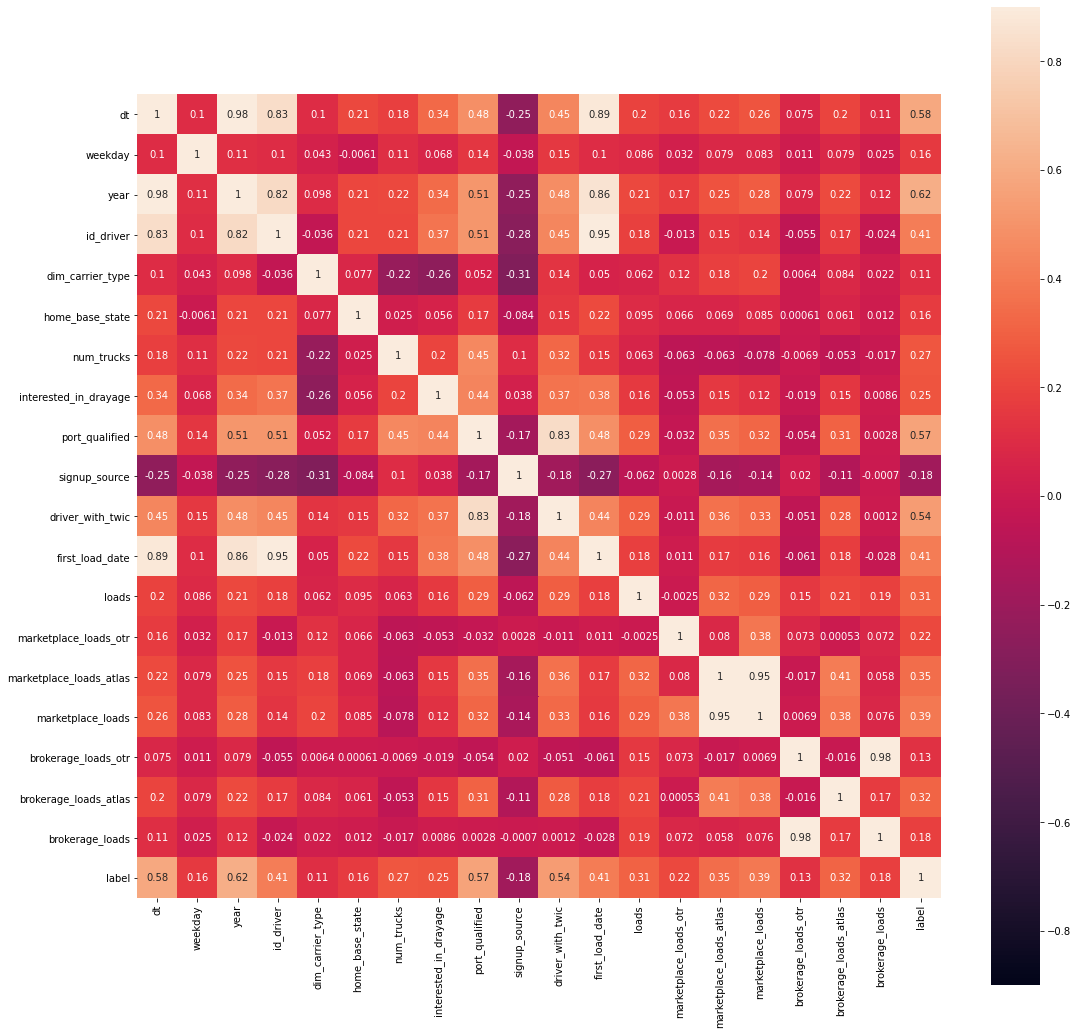

In [31]:
import seaborn as sns;
corr_data = labeled_data.corr(method ='pearson')
f, ax = plt.subplots(figsize=(18, 18))
ax = sns.heatmap(corr_data, square=True, vmin=-.9, vmax=.9, annot=True)


### Here we need to be aware of colinearities in our data. We see that dt, year, id_driver, and first_load_date are all highly correlated. In addition, it looks like brokerage_loads and brokerage_loads_otr are also very correlated.


Below is the balance of our dataset as displayed by a histogram of the labels. We have the expected 4:1 ratio of not high performing drivers to high performing drivers.

0    2824
1     706
Name: label, dtype: int64

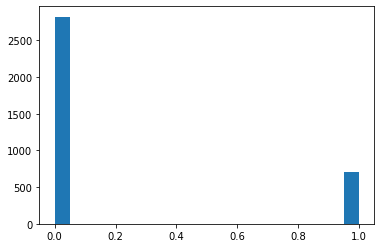

In [32]:
plt.hist(labeled_data['label'], bins=20)
plt.show
labeled_data['label'].value_counts()

# 4) Create a data feature extraction plan and implement a pipeline to execute it


## 4a) Determine which fields to retain and which to drop




We drop columns that are shown by the correlation matrix to have had an extremely low correlation with the label.

In [33]:
# Signup source has very little effect
labeled_data = labeled_data.drop(columns=['weekday','signup_source'])
kaggle_u_compressed = kaggle_u_compressed.drop(columns=['weekday','signup_source'])

Additionally we dropped columns that were deemed to be too complex to encode or to have too many null values to be useful before generating statistics. See above in step 3a.

## 4b) Determine a categorization strategy

We encoded all data for retained columns in step 3a above. This was so that we could generate the correlation matrix above as well as other useful statistics. 

## 4c) Determine an imputation strategy

We largely handled this above in step 3a. Below is a brief synopsis:

1. For num_trucks we used a KNN imputation where the value that replaces null is based on k similar rows

2. ts_first_approved, days_signup_to_approval, and dim_preferred_lanes were all dropped entirely due to having too high of a percentage of null values with little percieved value

3. home_base_state handled this in its encoding by changing null values to "0" which represents any state that is not CA

4. dim_carrier_company_name and home_base_city were dropped in their entirety due to being too difficult to encode without gaining a large amount of dimensionality

## 4d, 4e, and 4f

Pipeline:

Save labels for later:

In [34]:
labels = labeled_data["label"]
labels.shape

(3530,)

Remove labels to use in training:

In [35]:
unlabeled_data = labeled_data.drop("label", axis=1)
unlabeled_data.shape

(3530, 17)

### Create an augmented feature for 4d)

Our augmented feature is a feature cross between date and first load date to roughly represent the longevity of the driver.

In [36]:
unlabeled_data["longevity"] = unlabeled_data["dt"]/unlabeled_data["first_load_date"]
kaggle_u_compressed["longevity"] = kaggle_u_compressed["dt"]/kaggle_u_compressed["first_load_date"]
unlabeled_data.head()

,dt,year,id_driver,dim_carrier_type,home_base_state,num_trucks,interested_in_drayage,port_qualified,driver_with_twic,first_load_date,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,longevity
0,1613520000,2021,34586,0,1,195.0,1,1,1,1591833600,2,0,0,0,0,0,0,1.013624
1,1613520000,2021,18349,1,1,1.0,1,1,1,1582588800,3,2,116,118,2,148,150,1.019545
2,1613520000,2021,15704,1,1,1.0,0,0,0,1541980800,2,0,218,218,1,56,57,1.046394
3,1613520000,2021,37589,0,1,3.0,1,1,0,1610582400,5,0,67,67,0,1,1,1.001824
4,1613520000,2021,36275,1,1,1.0,1,1,1,1601769600,4,0,387,387,0,145,145,1.007336


Below is our implementation for 4e and 4f utilizing the standard scaler and a simple imputation strategy of median value imputation for any null values not handled already. The pipline also adds the augmented feature when passed a True agrument as the second parameter. 

In [37]:
imputer = SimpleImputer(strategy="median")

# column index
dt_ix, first_ix = 0, 9

#
class AugmentFeatures(BaseEstimator, TransformerMixin):
    '''
    implements the previous features we had defined
    labeled_data["longevity"] = labeled_data["dt"]/labeled_data["first_load_date"]
    '''
    def __init__(self, add_longevity): 
        self.add_longevity = add_longevity
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        if self.add_longevity:
          longevity = X[:, dt_ix] / X[:, first_ix]
          return np.c_[X, longevity]
        else:
          return np.c_[X]

def our_pipeline(dataset, augment):
  attr_adder = AugmentFeatures(add_longevity=augment)
  trucking_extra_attribs = attr_adder.transform(dataset.values)

  num_pipeline = Pipeline([
          ('imputer', SimpleImputer(strategy="median")),
          ('attribs_adder', AugmentFeatures(add_longevity=augment)),
          ('std_scaler', StandardScaler()),
      ])

  trucking_tr = num_pipeline.fit_transform(dataset)
  numerical_features = list(dataset)

  full_pipeline = ColumnTransformer([
          ("num", num_pipeline, numerical_features)
      ])

  return full_pipeline.fit_transform(dataset)

trucking_prepared = our_pipeline(unlabeled_data, True)
kaggle_prepared = our_pipeline(kaggle_u_compressed, True)

## 4g) Document your data strategy in your report

See report Methodology section for details on data strategy as well as experiments ran to select data. 

# 5) Implement a basic Linear Regression

In [38]:
trucking_reg = labeled_data.drop(columns=['id_driver', 'year', 'label', 'first_load_date', 'brokerage_loads_otr'])
reg_prepped = our_pipeline(trucking_reg, False)
trucking_reg.head()

,dt,dim_carrier_type,home_base_state,num_trucks,interested_in_drayage,port_qualified,driver_with_twic,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_atlas,brokerage_loads
0,1613520000,0,1,195.0,1,1,1,2,0,0,0,0,0
1,1613520000,1,1,1.0,1,1,1,3,2,116,118,148,150
2,1613520000,1,1,1.0,0,0,0,2,0,218,218,56,57
3,1613520000,0,1,3.0,1,1,0,5,0,67,67,1,1
4,1613520000,1,1,1.0,1,1,1,4,0,387,387,145,145


Above we dropped values with high colinearity for the linear regression model, including 'first_load_date'. Thus, when we run the pipeline on this subset of our data we do not include the augmented longevity feature since it is based off some of the dropped values. These determinations were made bassed off our correlation matrix in step 3b.

In [39]:
X2 = sm.add_constant(reg_prepped)
est = sm.OLS(labels, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     330.1
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        03:25:28   Log-Likelihood:                -442.80
No. Observations:                3530   AIC:                             911.6
Df Residuals:                    3517   BIC:                             991.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2000      0.005     43.239      0.0

We see that we should take these results with a grain of salt as there is still some colinearity present as per warining 2. That being said the p-values for x2 and x3 are well above 0.05 and thus are not likely to have any significant impact on the label prediction. Below we drop these values and repipeline our data to adjust for this fact. 

In [40]:
unlabeled_data = unlabeled_data.drop(columns=['dim_carrier_type','home_base_state'])
kaggle_u_compressed = kaggle_u_compressed.drop(columns=['dim_carrier_type','home_base_state'])

first_ix = 7

trucking_prepared = our_pipeline(unlabeled_data, True)
kaggle_prepared = our_pipeline(kaggle_u_compressed, True)



In [41]:
all_drivers = pd.concat([kaggle_u_compressed, unlabeled_data], axis=0)
all_drivers = all_drivers.sort_values(by=['dt'], axis=0, ascending=False)
all_drivers = all_drivers.reset_index().drop(columns=['index'])

all_drivers.drop_duplicates('id_driver', inplace = True)

all_drivers

,dt,year,id_driver,num_trucks,interested_in_drayage,port_qualified,driver_with_twic,first_load_date,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,longevity
0,1613520000,2021,26358,1.0,1,1,1,1574380800,3,0,34,34,0,159,159,1.024860
1,1613520000,2021,37047,1.0,1,1,1,1607126400,7,0,162,162,0,0,0,1.003978
2,1613520000,2021,17092,10.0,1,0,0,1548028800,1,5,3,8,143,1,144,1.042306
3,1613520000,2021,34794,195.0,1,1,1,1591228800,1,0,0,0,0,0,0,1.014009
4,1613520000,2021,32587,15.0,1,1,1,1592006400,3,1,46,47,0,47,47,1.013514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4522,1451347200,2015,125,1.0,0,0,0,1447891200,4,0,0,0,6,0,6,1.002387
4524,1450310400,2015,106,1.0,0,0,0,1449792000,1,0,0,0,5,0,5,1.000358
4525,1449619200,2015,27,1.0,0,0,0,1445126400,1,0,0,0,11,0,11,1.003109
4527,1448323200,2015,143,1.0,0,0,0,1446768000,2,0,0,0,23,0,23,1.001075


# 6) Implement Principle Component Analysis (PCA)

In [42]:
pca = PCA(n_components=7)
pca_vecs = pca.fit_transform(trucking_prepared)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

pca_vecs.shape

[0.30942371 0.17081783 0.11961424 0.0965457  0.08108702 0.05042855
 0.04559789]
[136.26634411 101.24612643  84.72337515  76.11640898  69.75695105
  55.01106761  52.30993745]


(3530, 7)

In [43]:
pca = PCA(n_components=7)
kaggle_pca_vecs = pca.fit_transform(kaggle_prepared)

In [44]:
pca = PCA(n_components=7)
all_drivers_pca = pca.fit_transform(all_drivers)

## Should we try having more PCA vecs???

# 7) Ensamble Method

We chose to use AdaBoost as our primary ensamble method given this method seems to be a relatively new and high performing model that avoids overfitting through the use of many weak learners.

### AdaBoost

In [45]:
X_train, X_test, y_train, y_test = train_test_split(pca_vecs, labels, test_size=0.2, random_state=0, shuffle=True)
X_train.shape

(2824, 7)

In [46]:
from sklearn.metrics import accuracy_score
tests = np.linspace(start=1, stop=100, num=100)
accus = []

for num_est in tests:
    ada = AdaBoostClassifier(base_estimator=None, random_state=10, learning_rate=1, n_estimators=int(num_est))
    ada.fit(X_train, y_train)
    y_pred_ada = ada.predict(X_test)
    accus.append(accuracy_score(y_test, y_pred_ada))
    
accu_arr = np.array(accus)

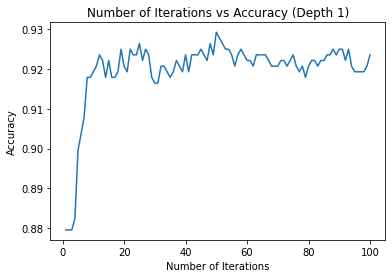

In [47]:
plt.plot(tests, accu_arr)
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy")
plt.title("Number of Iterations vs Accuracy (Depth 1)")
plt.show()

In [48]:
accus2 = []
rates = np.linspace(start=0.1, stop=2.0, num=20)

for lr in rates:
    ada = AdaBoostClassifier(base_estimator=None, random_state=10, n_estimators=50, learning_rate=lr)
    ada.fit(X_train, y_train)
    y_pred_ada = ada.predict(X_test)
    accus2.append(accuracy_score(y_test, y_pred_ada))

accu_arr = np.array(accus2)

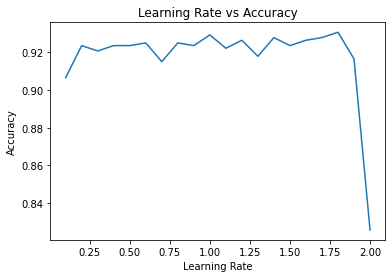

In [49]:
plt.plot(rates, accu_arr)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Learning Rate vs Accuracy")
plt.show()

In [50]:
from sklearn.model_selection import RandomizedSearchCV
import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 500, num = 20)]

# Learning Rate
learning_rate = [float(x) for x in np.linspace(start = 0.1, stop = 2.0, num = 20)]

# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(1, 5, num = 5)]
#max_depth.append(None)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate}
               #'max_depth': max_depth}

random_grid

{'learning_rate': [0.1,
  0.2,
  0.3,
  0.4,
  0.5,
  0.6,
  0.7,
  0.7999999999999999,
  0.8999999999999999,
  0.9999999999999999,
  1.0999999999999999,
  1.2,
  1.3,
  1.4,
  1.5,
  1.5999999999999999,
  1.7,
  1.8,
  1.9,
  2.0],
 'n_estimators': [1,
  27,
  53,
  79,
  106,
  132,
  158,
  184,
  211,
  237,
  263,
  289,
  316,
  342,
  368,
  394,
  421,
  447,
  473,
  500]}

The above grid of parameters are used to test for the best possible combination of parameters. Below is the code to determine these parameters via 5 fold kfold cross validation. 

In [51]:
sonic = AdaBoostClassifier()

rf_random = RandomizedSearchCV(estimator = sonic, param_distributions = random_grid, 
                            n_iter = 100, cv = 5, verbose=2, random_state=10, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=None,
                                                learning_rate=1.0,
                                                n_estimators=50,
                                                random_state=None),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6, 0.7,
                                                          0.7999999999999999,
                                                          0.8999999999999999,
                                                          0.9999999999999999,
                                                          1.0999999999999999,
                                                          1.2, 1.3, 1.4, 1.5,
                   

In [52]:
rf_random.best_params_

{'learning_rate': 0.3, 'n_estimators': 184}

In [53]:
ada = AdaBoostClassifier(base_estimator=None, random_state=10, learning_rate=1, n_estimators=368)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
print(f"Accuracy of best parameters: {accuracy_score(y_test, y_pred_ada)}")

Accuracy of best parameters: 0.9263456090651558


# 8) Neural net

We implemented two different forms of Neural Networks. We started by taking the starter code and retrofitting it for our needs using pytorch. 


In [54]:
import numpy as np
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
SEED = 1
# CUDA?
cuda = False

# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

In [55]:
from torch.utils.data import TensorDataset, DataLoader
X_train_float = X_train.astype(np.float32)
y_train_long = y_train.astype(np.long)

X_test_float = X_test.astype(np.float32)
y_test_long = y_test.astype(np.long)


X_train_torch = torch.from_numpy(X_train_float)
y_train_torch = torch.from_numpy(y_train_long.to_numpy())
X_test_torch = torch.from_numpy(X_test_float)
y_test_torch = torch.from_numpy(y_test_long.to_numpy())

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)

In [56]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [57]:
# One hidden Layer NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(7, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view((-1, 7))
        h = F.relu(self.fc(x))
        h = self.fc2(h)
        return F.log_softmax(h)    
    
#initialize the model   
network = Model()
if cuda:
    model.cuda() # CUDA!
#initialize the optimizer   
learning_rate = 0.025
momentum = 0.25
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [58]:
n_epochs = 3
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
log_interval = 100 

In [59]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [60]:
def test(): 
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / float(len(test_loader.dataset))))

In [61]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3442, Accuracy: 37/706 (5.24%)

Train Epoch: 1 [0/2824 (0%)]	Loss: 2.453657
Train Epoch: 1 [100/2824 (4%)]	Loss: 0.013942
Train Epoch: 1 [200/2824 (7%)]	Loss: 0.021404
Train Epoch: 1 [300/2824 (11%)]	Loss: 0.130228
Train Epoch: 1 [400/2824 (14%)]	Loss: 0.000137
Train Epoch: 1 [500/2824 (18%)]	Loss: 0.114912
Train Epoch: 1 [600/2824 (21%)]	Loss: 0.002487
Train Epoch: 1 [700/2824 (25%)]	Loss: 0.000055
Train Epoch: 1 [800/2824 (28%)]	Loss: 0.000434
Train Epoch: 1 [900/2824 (32%)]	Loss: 0.103703
Train Epoch: 1 [1000/2824 (35%)]	Loss: 0.000002
Train Epoch: 1 [1100/2824 (39%)]	Loss: 0.000000
Train Epoch: 1 [1200/2824 (42%)]	Loss: 0.047142
Train Epoch: 1 [1300/2824 (46%)]	Loss: 0.006304
Train Epoch: 1 [1400/2824 (50%)]	Loss: 0.000055
Train Epoch: 1 [1500/2824 (53%)]	Loss: 0.958577
Train Epoch: 1 [1600/2824 (57%)]	Loss: 0.207303
Train Epoch: 1 [1700/2824 (60%)]	Loss: 0.000024
Train Epoch: 1 [1800/2824 (64%)]	Loss: 0.005747
Train Epoch: 1 [1900/2824 (67%)]	Loss: 0.000054

We struggled Cross validating this, so we used keras to make another model

In [62]:
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.datasets import make_classification

In [63]:
# Number of features
number_of_features = 7

# Generate features matrix and target vector
features, target = make_classification(n_samples = int(pca_vecs.shape[0]/10),
                                       n_features = number_of_features,
                                       n_informative = 7,
                                       n_redundant = 0,
                                       n_classes = 7,
                                       random_state = 42)

In [64]:
def create_network():
    network = models.Sequential()
    network.add(layers.Dense(units=100, activation='relu', input_shape=(number_of_features,)))
    network.add(layers.Dense(units=100, activation='relu'))
    network.add(layers.Dense(units=1, activation='sigmoid'))

    network.compile(loss='binary_crossentropy', # Cross-entropy
                    optimizer='rmsprop', # Root Mean Square Propagation
                    metrics=['accuracy']) # Accuracy performance metric
    
    return network

Cross validation of this network shown below in section 9.

# 10) More Models

Moved part 10 above part 9 because part 9 cross validates all models including those implemented in 10

### Random Forest/Bagging

In [65]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 500, num = 20)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 1, 2, 3, 4, 5, 6]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
max_depth.append(None)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

random_grid

{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
 'max_features': ['auto', 'sqrt', 1, 2, 3, 4, 5, 6],
 'n_estimators': [1,
  27,
  53,
  79,
  106,
  132,
  158,
  184,
  211,
  237,
  263,
  289,
  316,
  342,
  368,
  394,
  421,
  447,
  473,
  500]}

In [66]:
from sklearn.ensemble import RandomForestClassifier

maokai = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = maokai, param_distributions = random_grid, 
                           n_iter = 100, cv = 5, verbose=2, random_state=10, n_jobs = -1)

# Fit the random search model

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [67]:
rf_random.best_params_

{'max_depth': None, 'max_features': 2, 'n_estimators': 106}

In [68]:
groot = RandomForestClassifier(n_estimators=132, max_features=2, max_depth=None, random_state=10, oob_score=True)
groot.fit(X_train, y_train)

groot_y_pred = groot.predict(X_test)
print(f"Accuracy of best parameters: {accuracy_score(y_test, groot_y_pred)}")

Accuracy of best parameters: 0.9575070821529745


### GradientBoost

In [69]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 500, num = 20)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 1, 2, 3, 4, 5, 6]

# learning rate
learning_rate = [float(x) for x in np.linspace(start = 0.1, stop = 2.0, num = 20)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
max_depth.append(None)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'learning_rate': learning_rate,
               'max_depth': max_depth}

random_grid

{'learning_rate': [0.1,
  0.2,
  0.3,
  0.4,
  0.5,
  0.6,
  0.7,
  0.7999999999999999,
  0.8999999999999999,
  0.9999999999999999,
  1.0999999999999999,
  1.2,
  1.3,
  1.4,
  1.5,
  1.5999999999999999,
  1.7,
  1.8,
  1.9,
  2.0],
 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
 'max_features': ['auto', 'sqrt', 1, 2, 3, 4, 5, 6],
 'n_estimators': [1,
  27,
  53,
  79,
  106,
  132,
  158,
  184,
  211,
  237,
  263,
  289,
  316,
  342,
  368,
  394,
  421,
  447,
  473,
  500]}

In [70]:
from sklearn.ensemble import GradientBoostingClassifier

grade = GradientBoostingClassifier()

rf_random = RandomizedSearchCV(estimator = grade, param_distributions = random_grid, 
                          n_iter = 100, cv = 5, verbose=2, random_state=10, n_jobs = -1)

# Fit the random search model

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 497 out of 500 | elapsed:  2.8min remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.9min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [71]:
rf_random.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 500}

In [72]:
pikachu = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_features='sqrt',
    max_depth=8, random_state=10)
pikachu.fit(X_train, y_train)
pikachu.score(X_test, y_test)

0.953257790368272

### K Nearest Neighbors

In [73]:
from sklearn.neighbors import KNeighborsClassifier
best_score = 0
best_k = 0
for k in range(1, 41):
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_train, y_train)
  preds = neigh.predict(X_test)
  score = accuracy_score(preds, y_test)
  if score > best_score:
    best_score = score
    best_k = k
print(f"Accuracy of best KNearestNeighbors at k={best_k}: {best_score}")

Accuracy of best KNearestNeighbors at k=1: 0.9518413597733711


## MLPClassifier: multi-layer perceptron classifier

In [74]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=10, max_iter=600, learning_rate='adaptive', shuffle=True)
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)

0.9660056657223796

### Stacking

In [76]:
from sklearn.ensemble import StackingClassifier


estimators = estimators = [
    ('rf', RandomForestClassifier(n_estimators=342, max_features='sqrt', max_depth=None, random_state=10, oob_score=True)),
    ('ada', AdaBoostClassifier(base_estimator=None, random_state=10, learning_rate=1, n_estimators=368)),
    ('grad', GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_features='sqrt',
    max_depth=8, random_state=10)),
    ('mlp', MLPClassifier(random_state=10, max_iter=600, learning_rate='adaptive', shuffle=True))
    ]

stack = StackingClassifier(estimators=estimators, cv=5, final_estimator=LogisticRegression())
stack.fit(X_train, y_train)
stack.score(X_test, y_test)

0.9660056657223796

# 9) Cross Validation of All Models


KFold Cross-Validation

In [77]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)

gradBoost = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_features='sqrt',
    max_depth=8, random_state=10)
bagging = RandomForestClassifier(n_estimators=342, max_features='sqrt', max_depth=None, random_state=10, oob_score=True)
adaBoost = AdaBoostClassifier(base_estimator=None, random_state=10, learning_rate=1, n_estimators=368)
neural_network = KerasClassifier(build_fn=create_network, 
                                 epochs=5, 
                                 batch_size=100, 
                                 verbose=0)
k_nearest = KNeighborsClassifier(n_neighbors=6)
stack = StackingClassifier(estimators=estimators, cv=5, final_estimator=LogisticRegression())
sk_mlp = MLPClassifier(random_state=10, max_iter=600, learning_rate='adaptive', shuffle=True)

grad_results = model_selection.cross_val_score(gradBoost, pca_vecs, labels, cv=kfold)
ada_results = model_selection.cross_val_score(adaBoost, pca_vecs, labels, cv=kfold)
bag_results = model_selection.cross_val_score(bagging, pca_vecs, labels, cv=kfold)
nn_results =  model_selection.cross_val_score(neural_network, pca_vecs, labels, cv=kfold)
k_nearest_results =  model_selection.cross_val_score(k_nearest, pca_vecs, labels, cv=kfold)
stack_results = model_selection.cross_val_score(stack, pca_vecs, labels, cv=kfold)
mlp_results = model_selection.cross_val_score(sk_mlp, pca_vecs, labels, cv=kfold)

print("Random Forest Accuracy: %.2f%%" % (ada_results.mean()*100.0))
print("AdaBoost Accuracy: %.2f%%" % (bag_results.mean()*100.0))
print("Neural Network Accuracy: %.2f%%" % (nn_results.mean()*100.0))
print("K Nearest Accuracy: %.2f%%" % (k_nearest_results.mean()*100.0)) 
print("GradientBoost Accuracy: %.2f%%" % (grad_results.mean()*100.0))
print("Stacking Accuracy: %.2f%%" % (stack_results.mean()*100.0))
print("mlp Accuracy: %.2f%%" % (mlp_results.mean()*100.0))

Random Forest Accuracy: 95.81%
AdaBoost Accuracy: 96.74%
Neural Network Accuracy: 95.33%
K Nearest Accuracy: 95.21%
GradientBoost Accuracy: 96.57%
Stacking Accuracy: 96.52%
mlp Accuracy: 97.28%


Stratified Shuffle Split

In [78]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

gradBoost = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_features='sqrt',
    max_depth=8, random_state=10)
bagging = RandomForestClassifier(n_estimators=342, max_features='sqrt', max_depth=None, random_state=10, oob_score=True)
adaBoost = AdaBoostClassifier(base_estimator=None, random_state=10, learning_rate=1, n_estimators=368)
neural_network = KerasClassifier(build_fn=create_network, 
                                 epochs=5, 
                                 batch_size=100, 
                                 verbose=0)
k_nearest = KNeighborsClassifier(n_neighbors=6)
stack = StackingClassifier(estimators=estimators, cv=5, final_estimator=LogisticRegression())
sk_mlp = MLPClassifier(random_state=10, max_iter=300, learning_rate='adaptive', shuffle=True)

grad_results_skf = model_selection.cross_val_score(gradBoost, pca_vecs, labels, cv=skf)
ada_results_skf = model_selection.cross_val_score(adaBoost, pca_vecs, labels, cv=skf)
bag_results_skf = model_selection.cross_val_score(bagging, pca_vecs, labels, cv=skf)
nn_results_skf =  model_selection.cross_val_score(neural_network, pca_vecs, labels, cv=skf)
k_nearest_results_skf =  model_selection.cross_val_score(k_nearest, pca_vecs, labels, cv=skf)
stack_results_skf = model_selection.cross_val_score(stack, pca_vecs, labels, cv=skf)
mlp_results_skf = model_selection.cross_val_score(sk_mlp, pca_vecs, labels, cv=skf)

print("Random Forest Accuracy: %.2f%%" % (ada_results_skf.mean()*100.0))
print("AdaBoost Accuracy: %.2f%%" % (bag_results_skf.mean()*100.0))
print("Neural Network Accuracy: %.2f%%" % (nn_results_skf.mean()*100.0)) 
print("K Nearest Accuracy: %.2f%%" % (k_nearest_results_skf.mean()*100.0)) 
print("GradientBoost Accuracy: %.2f%%" % (grad_results_skf.mean()*100.0))
print("Stacking Accuracy: %.2f%%" % (stack_results_skf.mean()*100.0))
print("mlp Accuracy: %.2f%%" % (mlp_results_skf.mean()*100.0))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Random Forest Accuracy: 95.47%
AdaBoost Accuracy: 96.49%
Neural Network Accuracy: 95.30%
K Nearest Accuracy: 95.01%
GradientBoost Accuracy: 96.35%
Stacking Accuracy: 96.46%
mlp Accuracy: 97.25%


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Our top performing model in both K-fold crossvalidation and stratified shuffle split validation was the MLP Neural Network. However, the best performing model on the Kaggle test set was AdaBoost. 

# 11) Kaggle Attempts


In [79]:
mlp_test = MLPClassifier(random_state=10, max_iter=600, learning_rate='adaptive', shuffle=True)
mlp_test.fit(X_train, y_train)
predictions = mlp_test.predict(all_drivers_pca)
#d = {'ID': kaggle_dirty['Unnamed: 0'], 'Predicted': predictions}
#kaggle_sub = pd.DataFrame(data=d)
#kaggle_sub.head(20)
len(predictions)
d = {'id_driver': all_drivers['id_driver'], 'Predicted': predictions}
kaggle_temp = pd.DataFrame(data=d)
kaggle_temp

,id_driver,Predicted
0,26358,0
1,37047,0
2,17092,0
3,34794,0
4,32587,0
...,...,...
4522,125,1
4524,106,1
4525,27,1
4527,143,1


In [80]:
driver_list = {}

for i in kaggle_temp.index:
  curr_driver = kaggle_temp['id_driver'][i]
  driver_list[curr_driver] = kaggle_temp['Predicted'][i]

new_predictions = []
for j in range(0, 1000):
  new_predictions.append(0)

kaggle_u_compressed['new_label'] = new_predictions

keys = []
for x in kaggle_u_compressed.index:
  key = kaggle_u_compressed['id_driver'][x]
  keys.append(key)
  if key in driver_list:
    kaggle_u_compressed['new_label'][x] = driver_list[key]

kaggle_u_compressed

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,dt,year,id_driver,num_trucks,interested_in_drayage,port_qualified,driver_with_twic,first_load_date,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,longevity,new_label
0,1569801600,2019,15857,2.0,0,0,0,1541376000,1,14,0,14,168,0,168,1.018442,0
1,1571875200,2019,28620,12.0,1,0,0,1569024000,1,13,5,18,34,0,34,1.001817,0
2,1567468800,2019,10694,1.0,0,0,1,1524441600,1,53,0,53,21,0,21,1.028225,0
3,1565136000,2019,12198,4.0,1,0,0,1533772800,6,69,38,107,18,0,18,1.020448,0
4,1540944000,2018,13222,2.0,1,0,0,1533686400,3,0,0,0,64,0,64,1.004732,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1537574400,2018,597,101.0,0,0,0,1460678400,1,0,0,0,62,0,62,1.052644,1
996,1593648000,2020,32167,1.0,0,0,0,1580774400,2,38,267,305,2,19,21,1.008144,0
997,1530057600,2018,7054,1.0,0,0,0,1523836800,1,19,5,24,11,0,11,1.004082,0
998,1490054400,2017,638,101.0,0,0,0,1459728000,1,0,0,0,119,0,119,1.020775,1


In [81]:
d = {'ID': kaggle_dirty['Unnamed: 0'], 'Predicted': kaggle_u_compressed['new_label']}
kaggle_sub = pd.DataFrame(data=d)
kaggle_sub.head(20)

,ID,Predicted
0,83414,0
1,83415,0
2,83416,0
3,83417,0
4,83418,1
5,83419,0
6,83420,0
7,83421,0
8,83422,0
9,83423,0


In [82]:
adaBoost = AdaBoostClassifier(base_estimator=None, random_state=10, learning_rate=1, n_estimators=368)
adaBoost.fit(X_train, y_train)
predictions2 = adaBoost.predict(kaggle_pca_vecs)
predictions2 = predictions2.flatten()

d = {'ID': kaggle_dirty['Unnamed: 0'], 'Predicted': predictions2}
kaggle_sub2 = pd.DataFrame(data=d)
kaggle_sub2.head(20)

,ID,Predicted
0,83414,0
1,83415,0
2,83416,0
3,83417,0
4,83418,0
5,83419,1
6,83420,1
7,83421,0
8,83422,1
9,83423,0


In [85]:
#kaggle_sub.to_csv('/content/gdrive/My Drive/kaggle_mlp_full.csv', index=False)

In [84]:
#kaggle_sub2.to_csv('/content/gdrive/My Drive/kaggle2-3.csv', index=False)